# Operation Identification using Deep Learning (Bi-LSTM w/ Softmax)
Each record in our dataset, SVAMP.json will be preprocessed.
The preprocessed records will be fed to a model which then identifies which one of the four operations is expected of the answer to that question. 

Since this deals only with elemnetary school level math problems, we assume that the only 4 operations are (ASMD) addition, subtraction, multiplication and division. There is no possibility of getting negative, decimal, fractional or profit loss questions.

I think I need a bigger dataset to train the operation identification.

## 1. Pre-Process SingleOp Dataset

1.1 Import Statements

In [2]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import string
import re
import nltk
import gensim

import matplotlib.pyplot as plt

1.2 Import JSON dataset into Dataframe

In [3]:
def readJsonToDf(path):
    df = pd.read_json(path)
    return df

In [4]:
# dataframe of SVAMP dataset
df = readJsonToDf('../../Datasets/singleop.json')

# columns of dataframe
print(list(df.columns))
df.head()

['iIndex', 'lAlignments', 'lEquations', 'lSolutions', 'sQuestion']


,iIndex,lAlignments,lEquations,lSolutions,sQuestion
0,0,"[13, 51]",[X=(7.0+7.0)],[14.0],If there are 7 bottle caps in a box and Linda ...
1,1,"[17, 40]",[X=(7.0+2.0)],[9.0],Jose starts with 7 bottle caps. He gets 2 more...
2,2,"[12, 34]",[X=(4.0+4.0)],[8.0],Bridget has 4 Skittles. Henry has 4 Skittles. ...
3,3,"[19, 40]",[X=(7.0+8.0)],[15.0],Brenda starts with 7 Skittles. She buys 8 more...
4,4,"[10, 19]",[X=(4.0+3.0)],[7.0],There are 4 cards. 3 cards more are added. How...


1.3.1 extract operation from equation into column "Type"

In [5]:
type(df['lEquations'][0])

list

In [6]:
# assumes SINGLE OP
def extract_op(row):
    if "+" in row['lEquations'][0]:
        return 'Addition'
    elif "-" in row['lEquations'][0]:
        return 'Subtraction'
    elif "*" in row['lEquations'][0]:
        return 'Multiplication'
    elif "/" in row['lEquations'][0]:
        return 'Division'

In [7]:
# apply func to df creating new column
df['Type'] = df.apply(lambda row: extract_op(row), axis=1)

1.3.1.1 Modify Columns, Drop Redundant Index

In [15]:
df.drop(['iIndex'], axis=1)

,lAlignments,lEquations,lSolutions,sQuestion,Type
0,"[13, 51]",[X=(7.0+7.0)],[14.0],If there are 7 bottle caps in a box and Linda ...,Addition
1,"[17, 40]",[X=(7.0+2.0)],[9.0],Jose starts with 7 bottle caps. He gets 2 more...,Addition
2,"[12, 34]",[X=(4.0+4.0)],[8.0],Bridget has 4 Skittles. Henry has 4 Skittles. ...,Addition
3,"[19, 40]",[X=(7.0+8.0)],[15.0],Brenda starts with 7 Skittles. She buys 8 more...,Addition
4,"[10, 19]",[X=(4.0+3.0)],[7.0],There are 4 cards. 3 cards more are added. How...,Addition
...,...,...,...,...,...
557,"[13, 27]",[X=(2.5-0.75)],[1.75],John needs $2.50. He has $0.75. How much more...,Subtraction
558,"[47, 25]",[X=(5.0-0.75)],[4.25],Jane buys an apple for $0.75 and pays with a ...,Subtraction
559,"[12, 47]",[X=(0.7-0.4)],[0.30000000000000004],John walks 0.7 miles to school and Nina walks...,Subtraction
560,"[19, 43]",[X=(28.3*5.0)],[141.5],One pencil weighs 28.3 grams. How much do 5 p...,Multiplication


In [20]:
df.columns = ['index', 'alignment', 'equation', 'solutions', 'question', 'Type']

<AxesSubplot:>

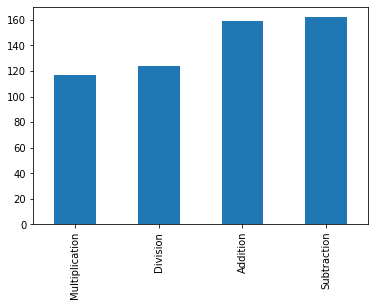

In [21]:
df.Type.value_counts().sort_values().plot(kind = 'bar')

#### 1.3.2 Remove Punctuation

I am removing all punctuation AND numbers from the body cuz I think it's irrelevent to my task of multi-class text classification.
If something's not working, toggle:
- the numbers
- ~~Stopwords~~

In [22]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [23]:
def clean_text(text):
    """
    text: a string

    return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ''.join([i for i in text if not i.isdigit()])
    text = " ".join(text.split())
    return text

In [24]:
#storing the punctuation free text
df['Clean']= df['question'].apply(lambda x:clean_text(x))

df['Clean'][1]

'jose starts with bottle caps he gets more from rebecca how many bottle caps does jose end with'

In [25]:
df.head()

,index,alignment,equation,solutions,question,Type,Clean
0,0,"[13, 51]",[X=(7.0+7.0)],[14.0],If there are 7 bottle caps in a box and Linda ...,Addition,if there are bottle caps in a box and linda pu...
1,1,"[17, 40]",[X=(7.0+2.0)],[9.0],Jose starts with 7 bottle caps. He gets 2 more...,Addition,jose starts with bottle caps he gets more from...
2,2,"[12, 34]",[X=(4.0+4.0)],[8.0],Bridget has 4 Skittles. Henry has 4 Skittles. ...,Addition,bridget has skittles henry has skittles if hen...
3,3,"[19, 40]",[X=(7.0+8.0)],[15.0],Brenda starts with 7 Skittles. She buys 8 more...,Addition,brenda starts with skittles she buys more how ...
4,4,"[10, 19]",[X=(4.0+3.0)],[7.0],There are 4 cards. 3 cards more are added. How...,Addition,there are cards cards more are added how many ...


### Save Data to CSV File

In [62]:
df.to_csv('cleaned_singleop.csv', sep=',', encoding='utf-8')

## 2. Build Model
4 classes are ['Addition','Division', 'Multiplication', 'Subtraction']

In [30]:
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import  Dense, Embedding, LSTM, Bidirectional

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from bs4 import BeautifulSoup

2.1 Define the Classes of the Multi-class Text Classification

In [28]:
# df['Type'].values

In [29]:
#  in ALPHABETICAL ORDER
operations = ['Addition','Division', 'Multiplication', 'Subtraction']

### 2.2 Vectorize our MWP

In [32]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 900
# Max number of words in each word problem.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.

EMBEDDING_DIM = 150
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Clean'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1093 unique tokens.


In [33]:
# Truncate and pad the input sequences so that they 
# are all in the same length for modeling.

X = tokenizer.texts_to_sequences(df['Clean'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (562, 100)


### Convert Categorical Labels to Numbers

Looks like get_dummies IS same OHE to category always. ORDER NOT MATTERS.

In [34]:
print(pd.get_dummies(df['Type']))

     Addition  Division  Multiplication  Subtraction
0           1         0               0            0
1           1         0               0            0
2           1         0               0            0
3           1         0               0            0
4           1         0               0            0
..        ...       ...             ...          ...
557         0         0               0            1
558         0         0               0            1
559         0         0               0            1
560         0         0               1            0
561         0         0               1            0

[562 rows x 4 columns]


In [35]:
Y = pd.get_dummies(df['Type']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (562, 4)


### 2.3 Train-Test Split

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.03, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(545, 100) (545, 4)
(17, 100) (17, 4)


### 2.4 Model

The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 4 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [38]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(Bidirectional(LSTM(64)))
# model.add(Dense(4, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
epochs = 10
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]

## 3. Evaluate Results

https://towardsdatascience.com/useful-plots-to-diagnose-your-neural-network-521907fa2f45

In [80]:
type(Y_test)

numpy.ndarray

### 3.1 Accuracy on Test Data

In [43]:
accuracy = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

1/1 [==============================] - 0s 35ms/step - loss: 0.7038 - accuracy: 0.8235
Test set
  Loss: 0.704
  Accuracy: 0.824


### 3.2 Plots for Diagnosis

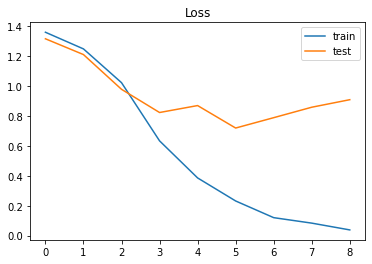

In [44]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

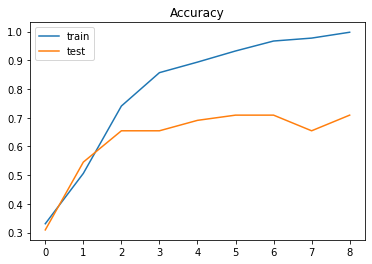

In [45]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### 3.3 Test on Custom Data

In [46]:
new_mwp = ['If Aditi has 2 toys, and he gives away 3. How many toys does he have now?']
new_mwp = [clean_text(x) for x in new_mwp]
seq = tokenizer.texts_to_sequences(new_mwp)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

pred = model.predict(padded)

print(pred, operations[np.argmax(pred)])

1/1 [==============================] - 0s 239ms/step
[[6.4944640e-02 8.2299218e-04 2.7190943e-03 9.3151331e-01]] Subtraction


Hmm. Looks like it's biased toward subtraction.

Why don't i try changing dataset? :
- make and use dataset with equal number of samples for each operation
- use a bigger dataset like m23 or dolphin ?

In [48]:
Y = [operations[np.argmax(x)] for x in model.predict(X)]

18/18 [==============================] - 0s 18ms/step


In [58]:
df['pred'] = Y
# df[['question', 'Type', 'pred']].tail(17)

In [52]:
pred = df[['question', 'Type', 'pred']].tail(17)
print(pred['pred'].value_counts())
pred['Type'].value_counts()

Subtraction       8
Addition          4
Multiplication    4
Division          1
Name: pred, dtype: int64


Subtraction       8
Addition          6
Multiplication    2
Division          1
Name: Type, dtype: int64

## Test with SVAMP data

In [72]:
svampdf = pd.read_csv('cleaned_svamp.csv')

In [73]:
svampdf

,Unnamed: 0,ID,Body,Question,Equation,Answer,Type,BQ,Clean
0,0,chal-1,Each pack of dvds costs 76 dollars. If there i...,How much do you have to pay to buy each pack?,( 76.0 - 25.0 ),51,Subtraction,Each pack of dvds costs 76 dollars. If there i...,each pack of dvds costs dollars if there is a ...
1,1,chal-2,Dan had $ 3 left with him after he bought a ca...,How much did the candy bar cost?,( 4.0 - 3.0 ),1,Subtraction,Dan had $ 3 left with him after he bought a ca...,dan had left with him after he bought a candy ...
2,2,chal-3,Paco had 26 salty cookies and 17 sweet cookies...,How many salty cookies did Paco have left?,( 26.0 - 9.0 ),17,Subtraction,Paco had 26 salty cookies and 17 sweet cookies...,paco had salty cookies and sweet cookies he at...
3,3,chal-4,43 children were riding on the bus. At the bus...,How many children got off the bus at the bus s...,( 43.0 - 21.0 ),22,Subtraction,43 children were riding on the bus. At the bus...,children were riding on the bus at the bus sto...
4,4,chal-5,28 children were riding on the bus. At the bus...,How many more children got on the bus than tho...,( 30.0 - 28.0 ),2,Subtraction,28 children were riding on the bus. At the bus...,children were riding on the bus at the bus sto...
...,...,...,...,...,...,...,...,...,...
995,995,chal-996,Paige was helping her mom plant flowers and to...,How many flower beds did they have?,( 36.0 / 12.0 ),3,Division,Paige was helping her mom plant flowers and to...,paige was helping her mom plant flowers and to...
996,996,chal-997,"At the zoo, a cage had 3 snakes and 75 alligat...",How many alligators were not hiding?,( 75.0 - 19.0 ),56,Subtraction,"At the zoo, a cage had 3 snakes and 75 alligat...",at the zoo a cage had snakes and alligators if...
997,997,chal-998,Paige was helping her mom plant flowers and to...,How many flowers did they grow?,( 60.0 * ( 55.0 / 15.0 ) ),220,Multiplication,Paige was helping her mom plant flowers and to...,paige was helping her mom plant flowers and to...
998,998,chal-999,Mary is baking a cake. The recipe calls for 7 ...,How many more cups of sugar does she need to add?,( 7.0 - 4.0 ),3,Subtraction,Mary is baking a cake. The recipe calls for 7 ...,mary is baking a cake the recipe calls for cup...


In [74]:
# Truncate and pad the input sequences so that they 
# are all in the same length for modeling.

XS = tokenizer.texts_to_sequences(svampdf['Clean'].values)
XS = pad_sequences(XS, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', XS.shape)

Shape of data tensor: (1000, 100)


In [75]:
YS = [operations[np.argmax(x)] for x in model.predict(XS)]

32/32 [==============================] - 1s 17ms/step


In [76]:
svampdf['pred'] = YS
pred = svampdf[['Question', 'Type', 'pred']].tail(17)
print(pred['pred'].value_counts())
pred['Type'].value_counts()

Subtraction       6
Multiplication    6
Addition          5
Name: pred, dtype: int64


Subtraction       8
Multiplication    4
Division          3
Addition          2
Name: Type, dtype: int64

In [81]:
YS = pd.get_dummies(svampdf['Type']).values

In [82]:
accuracy = model.evaluate(XS,YS)

32/32 [==============================] - 1s 17ms/step - loss: 1.8780 - accuracy: 0.4860


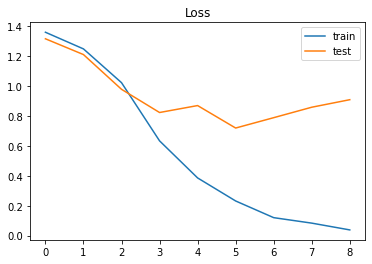

In [83]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

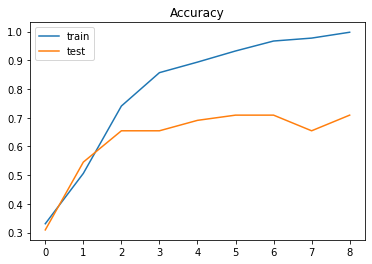

In [84]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

^^ TERRIBLE RESULTS
combine datasets and run ?